In [128]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [129]:
import numpy as np
import pandas as pd

In [130]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [131]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [132]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [133]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [134]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [135]:
# Save references to each table
Measurement = Base.classes.measurement 
Station = Base.classes.station

In [136]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [137]:
# Display the row's columns and data in dictionary format
measurement_first_row = session.query(Measurement).first()
measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x211cd371e08>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397'}

In [138]:
# Execute first five rows from Measurement 
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [139]:
# Display the row's columns and data in dictionary format
station_first_row = session.query(Station).first()
station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x211cd3a0348>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Climate Analysis

In [140]:
# To retrieve the last 12 months of precipitation data and plot the results

# Last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [141]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago =  dt.date(2017, 8, 23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [142]:
# Perform a query to retrieve the data and precipitation scores
query_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

In [184]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(query_data, columns=['Date', 'Precipitation'])

In [185]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df = df.groupby("Date").mean()
df = df.sort_values(by=['Date'])
df.head()

,Precipitation
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


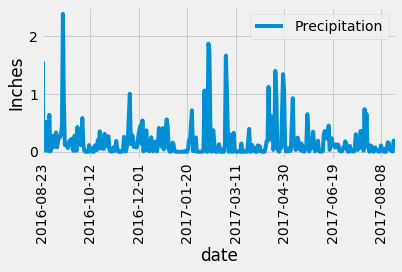

In [187]:
# Plot the analysis result 
df.plot()
plt.ylabel("Inches")
plt.xlabel("date")
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

# Station Analysis

In [147]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [153]:
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [154]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).first()
most_active_station

('USC00519281', 2772)

In [208]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station =='USC00519281').all()              
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station =='USC00519281').all()
ave_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station =='USC00519281').all()

print(f'Lowest temperature: {lowest_temp} \nHighest temperature: {highest_temp}\nAverage temperature: {ave_temp}')


# could get the data all by once 
query_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station =='USC00519281').all()

Lowest temperature: [(54.0,)] 
Highest temperature: [(85.0,)]
Average temperature: [(71.66378066378067,)]


<function matplotlib.pyplot.show(*args, **kw)>

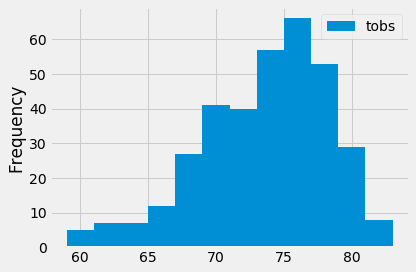

In [216]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_months_temp = session.query(Measurement.tobs).\
    filter(Measurement.station =='USC00519281').\
    filter(Measurement.date >= one_year_ago).all()

last_12_months_temp_df = pd.DataFrame(last_12_months_temp)
last_12_months_temp_df.plot.hist(bins = 12)
plt.tight_layout()
plt.show

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
